In [175]:
import pandas as pd
import matplotlib.pyplot as plt

In [194]:
telemetry = pd.read_json("../asset-1/telemetry.json")
telemetry=telemetry.rename(columns={0: "key", 1: "assetId", 2: "datetime", 3: "pressure", 4:"rotate", 5:"vibration", 6:"volt"})
telemetry=telemetry.drop(["key", "assetId"], axis=1)
telemetry['datetime']=pd.to_datetime(telemetry['datetime'])
telemetry.head()

,datetime,pressure,rotate,vibration,volt
0,2024-01-27 15:00:00,184.492462,391.584087,91.189581,45.477586
1,2024-03-22 11:00:00,174.431444,454.632591,94.156540,40.814789
2,2024-05-11 02:00:00,186.049455,471.071987,90.320956,41.057127
3,2024-02-24 14:00:00,190.364310,360.831575,103.767275,35.907194
4,2024-02-24 06:00:00,158.973418,414.889657,123.508070,45.309003


In [195]:
defects = pd.read_json("../asset-1/defects.json")
defects=defects.rename(columns={"Datetime": "datetime", "Type":"type"})
defects['datetime']=pd.to_datetime(defects['datetime'])
defects.head()

,datetime,type
0,2024-03-01 07:00:00,1
1,2024-03-01 20:00:00,3
2,2024-04-01 06:00:00,5
3,2024-10-01 15:00:00,4
4,2024-01-22 10:00:00,4


In [196]:
works = pd.read_json("../asset-1/works.json")
works=works.rename(columns={"Datetime": "datetime", "Type": "type"})
works['datetime']=pd.to_datetime(works['datetime'])
works=works.drop(["type"], axis=1)
works = works.rename(columns={'datetime': 'datetime_work'})

In [197]:
fails = pd.read_json("../asset-1/failures.json")
fails = fails.rename(columns={"Datetime": "datetime", "Type": "type"})
fails['datetime']=pd.to_datetime(fails['datetime'])
fails = fails.rename(columns={'datetime': 'datetime_fail', 'type': 'type_fail'})
fails

,datetime_fail,type_fail
0,2024-04-01 06:00:00,2
1,2024-05-03 06:00:00,1
2,2024-04-19 06:00:00,4
3,2024-04-19 06:00:00,4
4,2024-06-18 06:00:00,2
5,2024-01-09 06:00:00,2
6,2024-09-15 06:00:00,1


In [198]:
telemetry = telemetry.sort_values(by='datetime')
works = works.sort_values(by='datetime_work')
fails = fails.sort_values(by='datetime_fail')

In [199]:
telemetry = pd.merge_asof(telemetry, works, left_on='datetime', right_on='datetime_work', direction='backward')
telemetry['last_work'] = (telemetry['datetime'] - telemetry['datetime_work']).dt.total_seconds() / 3600
telemetry = pd.merge_asof(telemetry, fails, left_on='datetime', right_on='datetime_fail', direction='forward')
telemetry['rul'] = (telemetry['datetime_fail'] - telemetry['datetime']).dt.total_seconds() / 3600
telemetry = telemetry.sort_values(by='datetime')
telemetry.describe()

,datetime,pressure,rotate,vibration,volt,datetime_work,last_work,datetime_fail,type_fail,rul
count,7290,7290.000000,7290.000000,7290.000000,7290.000000,7290,7290.000000,6193,6193.000000,6193.000000
mean,2024-06-01 09:41:24.444444416,170.781930,446.416194,100.675573,40.555872,2024-05-18 19:44:53.333333504,325.941975,2024-06-12 11:04:22.166962688,1.740352,812.609075
min,2024-01-01 06:00:00,119.059047,215.619476,58.733724,22.666865,2023-12-13 06:00:00,0.000000,2024-01-09 06:00:00,1.000000,0.000000
25%,2024-03-18 04:15:00,160.317069,412.874152,93.409284,36.844111,2024-03-08 06:00:00,105.000000,2024-04-01 06:00:00,1.000000,271.000000
50%,2024-06-01 02:30:00,170.572593,447.668563,100.292000,40.336408,2024-05-20 06:00:00,228.000000,2024-06-18 06:00:00,2.000000,703.000000
75%,2024-08-16 00:45:00,180.895876,480.845511,107.337865,43.965956,2024-07-19 06:00:00,444.000000,2024-09-15 06:00:00,2.000000,1289.000000
max,2024-10-30 23:00:00,237.938518,617.475389,155.257527,67.633435,2024-10-17 06:00:00,1439.000000,2024-09-15 06:00:00,4.000000,2135.000000
std,NaN,15.291726,51.911118,10.814404,5.539654,NaN,312.620626,NaN,0.781580,605.498078


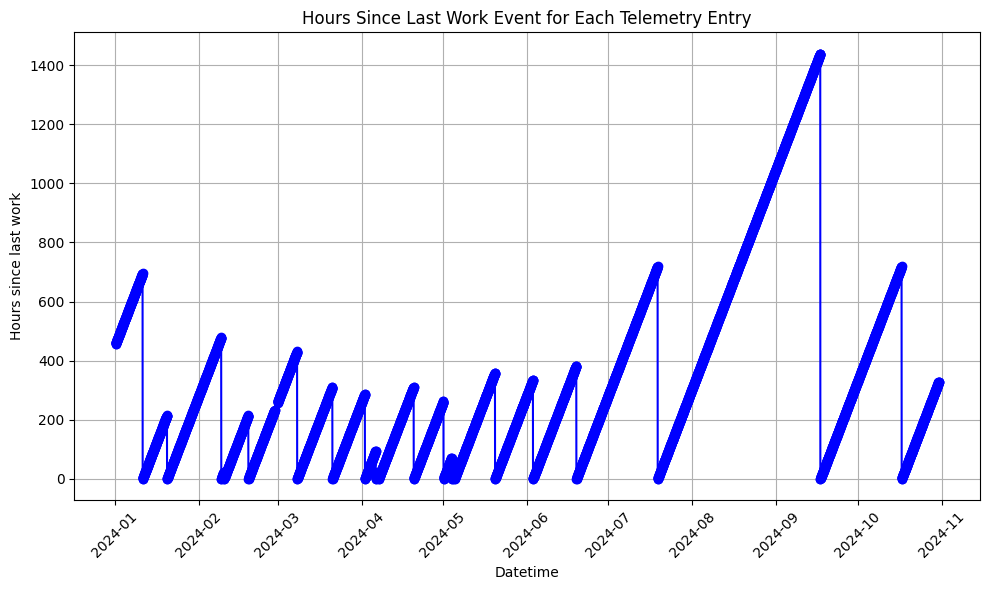

In [200]:
plt.figure(figsize=(10, 6))
plt.plot(telemetry['datetime'], telemetry['last_work'], marker='o', linestyle='-', color='b')
plt.xlabel('Datetime')
plt.ylabel('Hours since last work')
plt.title('Hours Since Last Work Event for Each Telemetry Entry')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [201]:
for error_type in range(1, 6):
    telemetry[f'error_{error_type}'] = 0

In [202]:
for idx, row in telemetry.iterrows():
    start_time = row['datetime_work']
    end_time = row['datetime']

    # Фильтруем ошибки в заданном временном диапазоне
    defects_in_range = defects[(defects['datetime'] > start_time) & (defects['datetime'] <= end_time)]

    # Считаем количество ошибок каждого типа и записываем в соответствующие столбцы
    error_counts = defects_in_range['type'].value_counts()
    for error_type, count in error_counts.items():
        telemetry.at[idx, f'error_{error_type}'] = count

In [203]:
telemetry['volt_last_hour'] = telemetry['volt'].shift(1)
telemetry['pressure_last_hour'] = telemetry['pressure'].shift(1)
telemetry['rotate_last_hour'] = telemetry['rotate'].shift(1)
telemetry['vibration_last_hour'] = telemetry['vibration'].shift(1)

In [204]:
telemetry['volt_change'] = telemetry['volt'] - telemetry['volt_last_hour']
telemetry['pressure_change'] = telemetry['pressure'] - telemetry['pressure_last_hour']
telemetry['rotate_change'] = telemetry['rotate'] - telemetry['rotate_last_hour']
telemetry['vibration_change'] = telemetry['vibration'] - telemetry['vibration_last_hour']

In [205]:
telemetry = telemetry.drop(["datetime_fail", "datetime_work"], axis=1)
telemetry = telemetry.drop(["volt", "pressure", "rotate", "vibration"], axis=1)
telemetry = telemetry.drop(["volt_last_hour", "pressure_last_hour", "rotate_last_hour", "vibration_last_hour"], axis=1)
telemetry = telemetry.dropna()
telemetry.to_csv("data.csv")

In [211]:
import pandas as pd
import matplotlib.pyplot as plt

telemetry = pd.read_json("../asset-1/telemetry.json")
telemetry=telemetry.rename(columns={0: "key", 1: "assetId", 2: "datetime", 3: "pressure", 4:"rotate", 5:"vibration", 6:"volt"})
telemetry=telemetry.drop(["key", "assetId"], axis=1)
telemetry['datetime']=pd.to_datetime(telemetry['datetime'])

defects = pd.read_json("../asset-1/defects.json")
defects=defects.rename(columns={"Datetime": "datetime", "Type":"type"})
defects['datetime']=pd.to_datetime(defects['datetime'])

works = pd.read_json("../asset-1/works.json")
works=works.rename(columns={"Datetime": "datetime_work", "Type": "type"})
works['datetime_work']=pd.to_datetime(works['datetime_work'])
works=works.drop(["type"], axis=1)

fails = pd.read_json("../asset-1/failures.json")
fails = fails.rename(columns={"Datetime": "datetime_fail", "Type": "type_fail"})
fails['datetime_fail']=pd.to_datetime(fails['datetime_fail'])

telemetry = telemetry.sort_values(by='datetime')
works = works.sort_values(by='datetime_work')
fails = fails.sort_values(by='datetime_fail')

telemetry = pd.merge_asof(telemetry, works, left_on='datetime', right_on='datetime_work', direction='backward')
telemetry['last_work'] = (telemetry['datetime'] - telemetry['datetime_work']).dt.total_seconds() / 3600
telemetry = pd.merge_asof(telemetry, fails, left_on='datetime', right_on='datetime_fail', direction='forward')
telemetry['rul'] = (telemetry['datetime_fail'] - telemetry['datetime']).dt.total_seconds() / 3600
telemetry = telemetry.sort_values(by='datetime')

for error_type in range(1, 6):
    telemetry[f'error_{error_type}'] = 0

for idx, row in telemetry.iterrows():
    start_time = row['datetime_work']
    end_time = row['datetime']

    defects_in_range = defects[(defects['datetime'] > start_time) & (defects['datetime'] <= end_time)]

    error_counts = defects_in_range['type'].value_counts()
    for error_type, count in error_counts.items():
        telemetry.at[idx, f'error_{error_type}'] = count

telemetry['volt_last_hour'] = telemetry['volt'].shift(1)
telemetry['pressure_last_hour'] = telemetry['pressure'].shift(1)
telemetry['rotate_last_hour'] = telemetry['rotate'].shift(1)
telemetry['vibration_last_hour'] = telemetry['vibration'].shift(1)

telemetry['volt_change'] = telemetry['volt'] - telemetry['volt_last_hour']
telemetry['pressure_change'] = telemetry['pressure'] - telemetry['pressure_last_hour']
telemetry['rotate_change'] = telemetry['rotate'] - telemetry['rotate_last_hour']
telemetry['vibration_change'] = telemetry['vibration'] - telemetry['vibration_last_hour']

telemetry = telemetry.drop(["datetime_fail", "datetime_work"], axis=1)
telemetry = telemetry.drop(["volt", "pressure", "rotate", "vibration"], axis=1)
telemetry = telemetry.drop(["volt_last_hour", "pressure_last_hour", "rotate_last_hour", "vibration_last_hour"], axis=1)
telemetry = telemetry.dropna()
telemetry.to_csv("data.csv")

In [212]:
telemetry

,datetime,last_work,type_fail,rul,error_1,error_2,error_3,error_4,error_5,volt_change,pressure_change,rotate_change,vibration_change
1,2024-01-01 07:00:00,457.0,2.0,191.0,0,0,0,0,0,-1.673713,-13.338630,-15.756589,-17.617410
2,2024-01-01 08:00:00,458.0,2.0,190.0,0,0,0,0,0,-9.235126,8.110680,124.602336,-20.222621
3,2024-01-01 09:00:00,459.0,2.0,189.0,0,0,0,0,0,6.943297,-8.527069,-181.200490,34.010656
4,2024-01-01 10:00:00,460.0,2.0,188.0,0,0,0,0,0,-15.131633,-4.852812,89.227538,2.638087
5,2024-01-01 11:00:00,461.0,2.0,187.0,0,0,0,0,0,9.664506,14.894818,-5.053511,-15.959607
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6188,2024-09-15 02:00:00,1388.0,1.0,4.0,1,1,2,0,0,-0.995586,-8.524450,-20.602502,-2.760423
6189,2024-09-15 03:00:00,1389.0,1.0,3.0,1,1,2,0,0,3.478542,-10.142440,40.884986,-12.234905
6190,2024-09-15 04:00:00,1390.0,1.0,2.0,1,1,2,0,0,0.450816,18.511955,-38.045723,1.695457
6191,2024-09-15 05:00:00,1391.0,1.0,1.0,1,1,2,0,0,-1.414400,-2.224265,-24.246620,24.618880
